In [2]:
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("../scripts")

import data
import experiments

In [29]:
def get_group_feature(dataset, X_train, X_val, X_test):
    """Function to get the sensitive attribute that defines binary group."""
    if dataset == "german":
        A_train = X_train.Gender.astype(str)
        A_val = X_val.Gender.astype(str)
        A_test = X_test.Gender.astype(str)
    elif dataset == "adult":
        A_train = X_train.sex.astype(str)
        A_val = X_val.sex.astype(str)
        A_test = X_test.sex.astype(str)
    elif dataset == "compas":
        A_train = X_train.race == "Caucasian"
        A_train = A_train.apply(lambda x: "Caucasian" if x else "Non-Caucasian")
        A_val = X_val.race == "Caucasian"
        A_test = X_test.race == "Caucasian"

    return A_train, A_val, A_test


def get_subgroup1_feature(dataset, X_train, X_val, X_test):
    """Function to get the sensitive attribute that defines 4 groups."""
    if dataset == "german":
        age = X_train.Age > 50
        age = age.apply(lambda x : " >50" if x else " <=50")
        A_train = X_train.Gender.astype(str) + " " + age.astype(str)
        A_val = X_val.Gender.astype(str) + "_" + (X_val.Age > 50).astype(str)
        A_test = X_test.Gender.astype(str) + "_" + (X_test.Age > 50).astype(str)
    elif dataset == "compas":
        caucasian = X_train.race == "Caucasian"
        caucasian = caucasian.apply(lambda x : "Caucasian" if x else "Non-Caucasian")
        age = (
            (X_train.age_cat == "25 - 45") | (X_train.age_cat == "Less than 25")
        )
        age = age.apply(lambda x : "<=45" if x else ">45")
        A_train = caucasian.astype(str) + " " + age.astype(str)
        A_val = (
            (X_val.race == "Caucasian").astype(str)
            + "_"
            + ((X_val.age_cat == "25 - 45") | (X_val.age_cat == "Less than 25")).astype(
                str
            )
        )
        A_test = (
            (X_test.race == "Caucasian").astype(str)
            + "_"
            + (
                (X_test.age_cat == "25 - 45") | (X_test.age_cat == "Less than 25")
            ).astype(str)
        )
    elif dataset == "adult":
        age = X_train.age > 50
        age = age.apply(lambda x : ">50" if x else "<=50")
        A_train = X_train.sex.astype(str) + " " + age
        A_val = X_val.sex.astype(str) + "_" + (X_val.age > 50).astype(str)
        A_test = X_test.sex.astype(str) + "_" + (X_test.age > 50).astype(str)

    return A_train, A_val, A_test


def get_subgroup2_feature(dataset, X_train, X_val, X_test):
    """Function to get the sensitive attribute that defines 8 groups."""

    def age_cat(age):
        if age < 30:
            return "< 30"
        elif age < 40:
            return "< 40"
        elif age < 50:
            return "< 50"
        else:
            return ">= 50"

    def race_cat(race):
        if race == "African-American" or race == "Hispanic":
            return "African-American or Hispanic"
        elif race == "Caucasian":
            return "Caucasian"
        elif race == "Asian":
            return "Asian"
        else:
            return "Native American or Other"

    if dataset == "german":
        A_train = (
            X_train.Gender.astype(str) + " " + X_train.Age.apply(age_cat).astype(str)
        )
        A_val = X_val.Gender.astype(str) + " " + X_val.Age.apply(age_cat).astype(str)
        A_test = X_test.Gender.astype(str) + " " + X_test.Age.apply(age_cat).astype(str)
    elif dataset == "adult":
        A_train = X_train.sex.astype(str) + " " + X_train.age.apply(age_cat).astype(str)
        A_val = X_val.sex.astype(str) + "_" + X_val.age.apply(age_cat).astype(str)
        A_test = X_test.sex.astype(str) + "_" + X_test.age.apply(age_cat).astype(str)
    elif dataset == "compas":
        race = X_train.race.apply(race_cat)
        age = (
            (X_train.age_cat == "25 - 45") | (X_train.age_cat == "Less than 25")
        )
        age = age.apply(lambda x : "<=45" if x else ">45")
        A_train = race.astype(str) + " " + age.astype(str)
        A_val = (
            X_val.race.apply(race_cat)
            + "_"
            + ((X_val.age_cat == "25 - 45") | (X_val.age_cat == "Less than 25")).astype(
                str
            )
        )
        A_test = (
            X_test.race.apply(race_cat)
            + "_"
            + (
                (X_test.age_cat == "25 - 45") | (X_test.age_cat == "Less than 25")
            ).astype(str)
        )

    return A_train, A_val, A_test



In [35]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
}

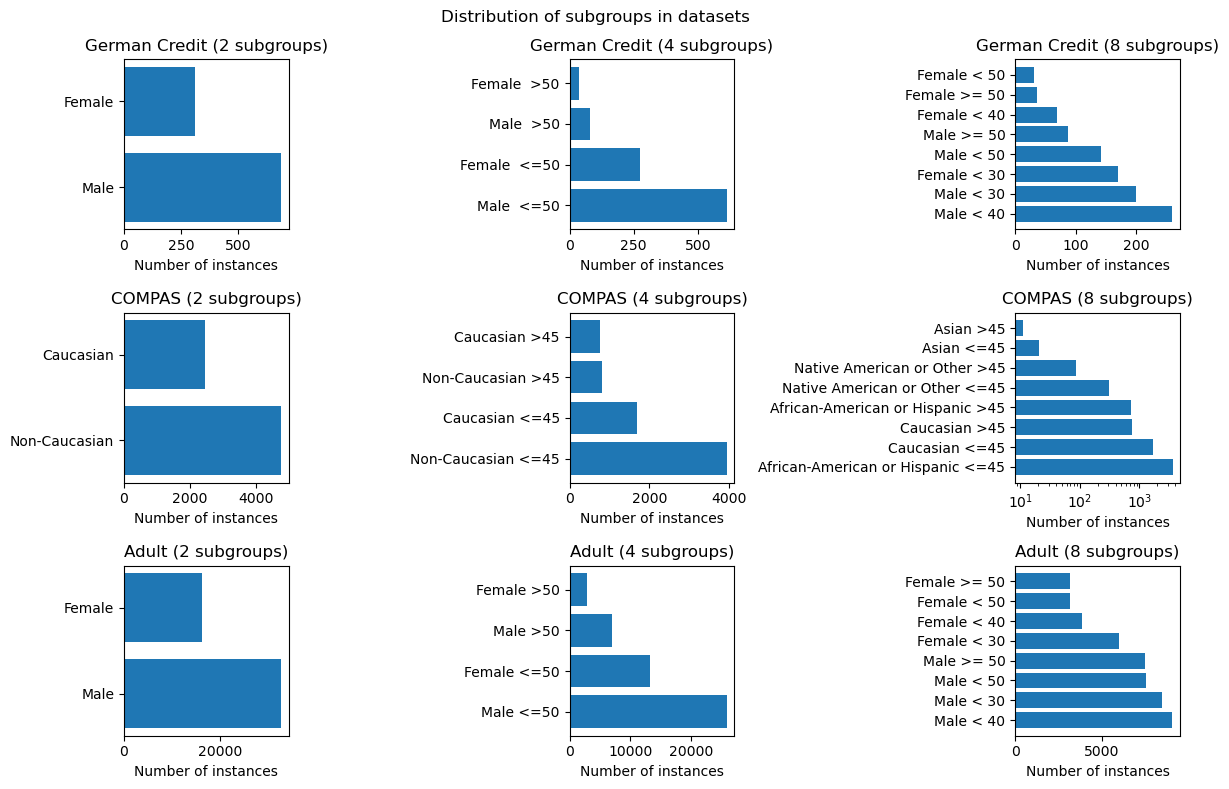

In [42]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 8))

for i, dataset in enumerate(["german", "compas", "adult"]):

    X, Y = data.load_dataset(dataset)

    A, _, _ = get_group_feature(dataset, X, X, X)
    count = A.value_counts()
    axs[i, 0].barh(count.index, count.values)

    A, _, _ = get_subgroup1_feature(dataset, X, X, X)
    count = A.value_counts()
    axs[i, 1].barh(count.index, count.values)

    A, _, _ = get_subgroup2_feature(dataset, X, X, X)
    count = A.value_counts()
    axs[i, 2].barh(count.index, count.values)

    if i == 1:
        axs[i, 2].set_xscale("log")

    axs[i, 0].set_title(dataset_names[dataset] + " (2 subgroups)")
    axs[i, 1].set_title(dataset_names[dataset] + " (4 subgroups)")
    axs[i, 2].set_title(dataset_names[dataset] + " (8 subgroups)")
    axs[i, 0].set_xlabel("Number of instances")
    axs[i, 1].set_xlabel("Number of instances")
    axs[i, 2].set_xlabel("Number of instances")


plt.suptitle("Distribution of subgroups in datasets")
plt.tight_layout()
plt.savefig("../figs/subgroups.pdf", dpi = 300)
plt.show()
